In [1]:
#Ning
#17 Nov
#Metaheuristics TP5

#import statements
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import math
import random

In [2]:
#preliminary look at the X.dat file and Y.dat file
#Note that 0 corresponds to 'two' and 1 corresponds to 'three'

def transfer_file_to_arrays (filename):
    
    images = []
    
    with open(filename, "r") as fp:
        for line in fp:
            line = line.split(",") #split values on ,
            for i in range(0, len(line)):
                line[i] = float(line[i]) #turn into a float
            line = np.array(line)
            images.append(line) #append in np array format

    return images

def get_labels (filename):
    labels = []
    with open(filename, "r") as fp:
        for line in fp:
            labels.append(float(line))
    return labels

In [3]:
images = transfer_file_to_arrays("X.dat")
print(len(images)) #confirm that we have 200 images stored
print(images[0].shape[0]) #confirm the shape of the image
labels = get_labels("Y.dat")
print(len(labels))

200
400
200


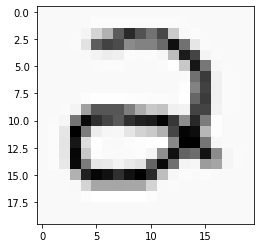

In [4]:
#show a sample of the image to see if we have one
plt.imshow(np.reshape(images[2], (20,20), order="F"), cmap="Greys")

In [120]:
def turn_two_to_one (theta1, theta2):
    return np.concatenate((theta1.flatten(), theta2.flatten()), axis=None)

def turn_one_to_two (big_theta):
    
    theta1 = np.reshape(big_theta[0:10025], (25,401)) #need to be careful here because of shape
    theta2 = np.reshape(big_theta[10025:], (1,26))
    
    return theta1, theta2

In [90]:
#testing
a = 6*np.zeros((25,401))-3
b = 6*np.full((1,26),1)-3

ab = turn_two_to_one(a,b)
c,d = turn_one_to_two(ab)

print(a==c)
print(b==d)

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True]]


In [91]:
def sigmoid (X):
    return 1/(1+np.exp(-X))

def first_layer (picture):
    '''
    first layer's role is to download the 400 pixels of the picture
    and have one neuron that is the bias 
    '''
    #add bias neuron
    layer_n = picture.shape[0]
    first_layer = np.insert(picture, 0, 1.0) #add 1 as the bias
    
    return first_layer

def second_layer (layer, theta):
    '''
    second layer contains 25 neurons, plus 1 for the bias
    job is to matmul the first layer's output with theta, apply sigmoid function, add bias
    
    theta is the matrix of size (25, 401)
    '''
    
    res = np.matmul(theta, layer) #should be a matmul of sizes (25,401)(401,) -> (25,)
    
    #apply the sigmoid function
    res = sigmoid(res)
    
    res_n = res.shape[0] #should be 25
    
    second_layer = np.insert(res, 0, 1.0) #add 1 as the bias
    
    return second_layer

def third_layer (layer, theta):
    '''
    third layer contains 1 neuron
    job is to matmul the second layer's output with theta, apply sigmoid function, and return
    
    theta is the matrix of size (1, 26)
    '''
    
    res = np.matmul(theta, layer) #should be a matmul of sizes (1,26)(26,) -> (1,)
    
    #apply the sigmoid function
    res = sigmoid(res)
    
    return res #should be a singular value answer, our prediction

def nn_predict (image, big_theta):
    '''
    application of all three layers
    '''
    
    #temporary values
    theta1, theta2 = turn_one_to_two(big_theta)
    
    layer1 = first_layer(image)
    layer2 = second_layer(layer1, theta1) #this theta value will take on PSO's output once complete
    layer3 = third_layer(layer2, theta2)
    
    return layer3[0] #the prediction    

In [118]:
#do some testing with values, we should be able to get a value
test = images[2]
print(nn_predict(test, ab))

0.9525741268224334


Well, that certainly looks like a value. Good job kense. Time to start PSO

In [93]:
def calc_fitness(big_theta, images, labels):
    fitness = 0.0
    for k in range(0, len(labels)):
        fitness+=(labels[k] - nn_predict(images[k], big_theta))**2
    return fitness/len(labels)

In [119]:
t1 = np.random.rand(25,401)
t2 = np.random.rand(1,26)
bt = turn_two_to_one(t1,t2)
print(calc_fitness(bt, images, labels))

0.49999955032243937


In [100]:
def init_positions ():
    return 2*np.random.rand(25,401)-1, 2*np.random.rand(1,26)-1

def init_velocities ():
    return np.zeros((25,401)), np.zeros((1,26))

In [154]:
def PSO (n, tmax, images, labels):
    
    #variables
    global_best = [None,float('inf')] #global_best is (position, fitness)
    inertia_constant = 0.9
    c1 = 1.99811 #defined by the assignment as close to 2
    c2 = 1.99899
    t = 0
    vmax = 0.015
    
    #initialize particles -> (s, v, b)
    particles = []
    for i in range(n):
        s0_a, s0_b = init_positions()
        v0_a, v0_b = init_velocities()
        
        big_s0 = turn_two_to_one(s0_a, s0_b)
        big_v0 = turn_two_to_one(v0_a, v0_b)
        particle = [big_s0, big_v0, big_s0] #personal_best init is s0
        particles.append(particle)
   
    
    while(t < tmax):
        
        #for each particle
        for i in range(n):
            fit = calc_fitness(particles[i][0], images, labels) #positions are taken to calc fitness
            pbest_fit = calc_fitness(particles[i][2], images, labels)
            if fit <= pbest_fit: #if better than personal_best
                particles[i][2] = particles[i][0][:] #copy as new best
        
        #set global_best
        for i in range(n):
            fit = calc_fitness(particles[i][2], images, labels)
            if fit <= global_best[1]: #if personal_best better than global_best
                global_best[1] = fit
                global_best[0] = particles[i][2][:] #set new values for global
        
        #for each particle, update s and v
        for i in range(n):
            r1 = random.random()
            r2 = random.random()
            
            #for each particle, update its particles...
            for x in range(len(particles[i][1])): #update each particle's v
                particles[i][1][x] = (inertia_constant*particles[i][1][x]) + (c1*r1*(particles[i][2][x]-particles[i][0][x])) + (c2*r2*(global_best[0][x]-particles[i][0][x]))
                
                #velocity cutoff?
                if abs(particles[i][1][x]) >= vmax:
                    particles[i][1][x] = vmax*np.sign(particles[i][1][x])
            
            #particles[i][0] = np.add(particles[i][0],particles[i][1]) #then update s
            for x in range(len(particles[i][0])):
                particles[i][0][x] = particles[i][0][x] + particles[i][1][x]
                
                #correct if particle is out of the problem range
                if particles[i][0][x] > 1:
                    particles[i][0][x] = particles[i][0][x]-(2*(particles[i][0][x]- 1))
                elif particles[i][0][x] < -1:
                    particles[i][0][x] = particles[i][0][x] + (2*(-1-particles[i][0][x]))
                
        
        t = t + 1
    
    #get the stats of the global_best
    theta1, theta2 = turn_one_to_two(global_best[0]) #separate global_best's particle into thetas
    return theta1, theta2 #return

In [158]:
#testing
a,b = PSO(10, 200, images, labels)

print(a,b)

[[-0.3295127   0.21406612  0.00771421 ...  0.99995993  0.2647482
  -0.14553244]
 [ 0.48139067  0.32889793 -0.9999634  ... -0.23382453  0.99999658
   0.57220019]
 [ 0.62631849  0.3422951  -0.58160144 ...  0.18284844  0.26695769
  -0.48085509]
 ...
 [ 0.13292437  0.01594303 -0.27852383 ... -0.56929989 -0.52981627
  -0.33585337]
 [ 0.11889242 -0.73301057 -0.18312435 ... -0.26541761 -0.27228945
  -0.13019358]
 [-0.1233251  -0.49501808 -0.05144692 ...  0.55886783  0.31116364
   0.9114545 ]] [[-0.97300254  0.42951872  0.99999985 -0.28952958 -0.73499469  0.23019052
   0.15466653 -0.49547932  0.82678698 -0.41152303 -0.14845732 -0.13561658
  -0.30047556 -0.99775014 -0.99999962 -0.60722338  0.99953507 -0.05269004
  -0.40442427 -0.81583628  0.76063566 -0.09838725  0.77322562 -0.06674004
   0.05971625  0.99999976]]


In [159]:
#error testing
correct = 0
predictions = []
for i in range(len(images)):
    predict = nn_predict(images[i], turn_two_to_one(a,b))
    predictions.append(predict)
    truth = labels[i]
    
    if truth == int(predict+0.5):
        correct += 1
print(correct/len(labels))

0.785


In [160]:
predictions

[0.6818596119378255,
 0.18315198109914838,
 0.284968830572316,
 0.23358290373526472,
 0.7097851569790743,
 0.6746848056641557,
 0.34406109547947844,
 0.8504675269445285,
 0.661070470589681,
 0.2999071983295689,
 0.5605585561190434,
 0.4104353597372886,
 0.724428609276207,
 0.22665086754893896,
 0.6129392867527124,
 0.7261789506621835,
 0.5928500171262814,
 0.7560024140705034,
 0.4579903224792445,
 0.546339952079649,
 0.7878436786340643,
 0.6054562667466653,
 0.4999761157573643,
 0.6283933027649026,
 0.692354664855131,
 0.18222156365670147,
 0.40768253029787277,
 0.7560235499689631,
 0.4957987040622077,
 0.5751528564560293,
 0.5508845977007547,
 0.5587179773041725,
 0.30782725823590723,
 0.735033953850671,
 0.8529089018844372,
 0.42890028495756605,
 0.33611782241605537,
 0.5251759324316793,
 0.7993966994281329,
 0.6476227881193465,
 0.5366170339859723,
 0.7277741539482947,
 0.38304497158229345,
 0.661045354216642,
 0.5904585422540742,
 0.681371189810609,
 0.869642744888264,
 0.443149038